# Adatbetoltes

In [1]:
import os
import json
import pandas as pd
import glob
import re
import numpy as np

# --- KONFIGURÁCIÓ ---
N_BARS_LOOKBACK = 100
DATA_ROOT = "../data/bullflagdetector/bullflagdetector"
OUTPUT_DIR = "./output"

In [2]:
def robust_parse_ts(value):
    """Kezeli a Unix ms, Unix s és ISO string formátumokat is."""
    try:
        if pd.isna(value) or value == "": return pd.NaT
        if str(value).isdigit() or isinstance(value, (int, float)):
            val_int = int(value)
            if val_int > 30000000000: return pd.to_datetime(val_int, unit='ms')
            else: return pd.to_datetime(val_int, unit='s')
        return pd.to_datetime(value)
    except:
        return pd.NaT

def get_uniform_name(filename):
    if not filename: return "UNKNOWN"
    clean = filename
    if '-' in filename: parts = filename.split('-', 1); clean = parts[1] if len(parts)>1 else clean
    base = os.path.splitext(clean)[0]
    parts = base.split('_')
    if len(parts) >= 2:
        asset = parts[0]; tf = parts[1]
        if re.search(r'\d+\s*(minute|min|m|M)$', tf, re.IGNORECASE):
            tf = re.sub(r'(minute|min|m|M)$', 'min', tf, flags=re.IGNORECASE)
        elif re.search(r'\d+\s*(hour|h)$', tf, re.IGNORECASE):
            tf = re.sub(r'(hour|h)$', 'H', tf, flags=re.IGNORECASE)
        return f"{asset}_{tf}"
    return base

# ==========================================
# KONFLIKTUSKEZELÉS
# ==========================================
def filter_overlaps(df):
    """
    Kiszűri a duplikációkat és a súlyos átfedéseket.
    """
    if df.empty: return df

    print("\n[SZŰRÉS] Átfedések és duplikációk vizsgálata...")
    original_count = len(df)

    # 1. Teljes duplikátumok törlése
    df['start_round'] = df['flag_start_ts'].dt.round('1min')
    df['end_round'] = df['flag_end_ts'].dt.round('1min')

    # Megtartjuk az elsőt
    df = df.drop_duplicates(subset=['raw_csv_filename', 'start_round', 'end_round', 'label'], keep='first')

    # 2. Konfliktusok keresése
    df = df.sort_values(by=['raw_csv_filename', 'flag_start_ts'])
    indices_to_drop = []

    for group_name, group in df.groupby('raw_csv_filename'):
        group = group.reset_index()
        for i in range(len(group) - 1):
            curr = group.iloc[i]
            next_row = group.iloc[i+1]

            # Átfedés vizsgálata
            if curr['flag_end_ts'] > next_row['flag_start_ts']:
                intersection = min(curr['flag_end_ts'], next_row['flag_end_ts']) - next_row['flag_start_ts']
                union = max(curr['flag_end_ts'], next_row['flag_end_ts']) - curr['flag_start_ts']

                if union.total_seconds() > 0:
                    overlap_ratio = intersection.total_seconds() / union.total_seconds()
                else:
                    overlap_ratio = 0

                if overlap_ratio > 0.5:
                    if curr['label'] != next_row['label']:
                        print(f"    [KONFLIKTUS] {group_name}: Megtartva: {curr['label']} | Eldobva: {next_row['label']}")
                    indices_to_drop.append(next_row['index'])

    if indices_to_drop:
        df = df.drop(indices_to_drop)
        print(f"    -> Eltávolítva {len(indices_to_drop)} db konfliktusos sor.")

    df = df.drop(columns=['start_round', 'end_round'])
    print(f"    -> Maradt: {len(df)} (Eredeti: {original_count})")
    return df

# ==========================================
# 1. FÁZIS: CSV ÖSSZEFŰZÉS
# ==========================================
def merge_and_save_csvs(data_dir, output_dir):
    print("\n[1. FÁZIS] CSV fájlok keresése és összefűzése...")
    all_csvs = glob.glob(os.path.join(data_dir, "**/*.csv"), recursive=True)
    grouped_dfs = {}

    for csv_path in all_csvs:
        if output_dir in csv_path: continue
        group_name = get_uniform_name(os.path.basename(csv_path))
        try:
            with open(csv_path, 'r') as f: line = f.readline()
            sep = ';' if ';' in line else ','
            df = pd.read_csv(csv_path, sep=sep)
            df.columns = df.columns.str.lower().str.strip()

            t_col = next((c for c in df.columns if 'time' in c or 'date' in c), df.columns[0])
            vals = pd.to_numeric(df[t_col], errors='coerce')
            if vals.notna().mean() > 0.8:
                if vals.max() > 300000000000: df['dt'] = pd.to_datetime(vals, unit='ms')
                else: df['dt'] = pd.to_datetime(vals, unit='s')
            else:
                df['dt'] = pd.to_datetime(df[t_col], errors='coerce')

            df = df.dropna(subset=['dt']).set_index('dt')
            cols = [c for c in df.columns if c in ['open', 'high', 'low', 'close', 'volume']]
            df = df[cols]

            if group_name not in grouped_dfs: grouped_dfs[group_name] = []
            grouped_dfs[group_name].append(df)
        except: pass

    saved_map = {}
    os.makedirs(output_dir, exist_ok=True)
    for group_name, df_list in grouped_dfs.items():
        if not df_list: continue
        full_df = pd.concat(df_list).sort_index()
        full_df = full_df[~full_df.index.duplicated(keep='first')]
        save_path = os.path.join(output_dir, f"merged_{group_name}.csv")
        full_df.to_csv(save_path)
        saved_map[group_name] = save_path
        print(f"    -> Mentve: merged_{group_name}.csv ({len(full_df)} sor)")
    return saved_map

# ==========================================
# 2. FÁZIS: CÍMKE FELDOLGOZÁS
# ==========================================
def find_best_pole(label_row, ohlcv_df):
    try:
        anchor_idx = ohlcv_df.index.get_indexer([label_row['flag_start_ts']], method='nearest')[0]
        anchor_bar = ohlcv_df.iloc[anchor_idx]
        if abs((anchor_bar.name - label_row['flag_start_ts']).total_seconds()) > 14400: return None
    except: return None

    best_ts = None; max_slope = -float('inf')
    for i in range(1, N_BARS_LOOKBACK + 1):
        cand_idx = anchor_idx - i
        if cand_idx < 0: break
        cand_bar = ohlcv_df.iloc[cand_idx]
        p_change = 0.0
        if label_row['pattern_type'] == "BULL_FLAG": p_change = anchor_bar['high'] - cand_bar['low']
        elif label_row['pattern_type'] == "BEAR_FLAG": p_change = cand_bar['high'] - anchor_bar['low']

        if p_change > 0:
            slope = p_change / i
            if slope > max_slope: max_slope = slope; best_ts = cand_bar.name
    return best_ts

def process_labels(data_dir, output_dir, merged_files_map):
    print("\n[2. FÁZIS] Címkék feldolgozása...")
    json_files = glob.glob(os.path.join(data_dir, "**/*.json"), recursive=True)
    final_dataset = []
    loaded_dfs = {}

    for jpath in json_files:
        if 'sample' in jpath or 'consensus' in jpath: continue
        try:
            with open(jpath, 'r') as f: content = json.load(f)
            if isinstance(content, dict): content = [content]
            for task in content:
                ls_filename = task.get('file_upload')
                if not ls_filename: continue
                uniform_name = get_uniform_name(ls_filename)

                merged_path = merged_files_map.get(uniform_name)
                if not merged_path:
                    for k, v in merged_files_map.items():
                        if uniform_name in k: merged_path = v; uniform_name = k; break
                if not merged_path: continue

                if uniform_name not in loaded_dfs:
                    loaded_dfs[uniform_name] = pd.read_csv(merged_path, index_col=0, parse_dates=True)
                ohlcv_df = loaded_dfs[uniform_name]

                for ann in task.get('annotations', []):
                    for res in ann.get('result', []):
                        val = res.get('value', {})
                        if val.get('timeserieslabels'):
                            lbl = val['timeserieslabels'][0]

                            # Típus meghatározása
                            p_type = "BULL_FLAG" if "Bullish" in lbl else "BEAR_FLAG" if "Bearish" in lbl else "UNKNOWN"

                            # --- ÚJ: TREND CÍMKE (BULL / BEAR) ---
                            trend = "UNKNOWN"
                            if p_type == "BULL_FLAG": trend = "BULL"
                            elif p_type == "BEAR_FLAG": trend = "BEAR"

                            start_ts = robust_parse_ts(val['start'])
                            end_ts = robust_parse_ts(val['end'])
                            if pd.isna(start_ts): continue

                            temp_row = {'flag_start_ts': start_ts, 'pattern_type': p_type}
                            pole_ts = find_best_pole(temp_row, ohlcv_df)

                            if pole_ts:
                                final_dataset.append({
                                    "full_filename": ls_filename,
                                    "raw_csv_filename": uniform_name,
                                    "merged_csv_path": f"merged_{uniform_name}.csv",
                                    "label": lbl,          # Pl: "Bullish Wedge"
                                    "trend_label": trend,  # Pl: "BULL"
                                    "flag_start_ts": start_ts,
                                    "flag_end_ts": end_ts,
                                    "pole_start_ts": pole_ts,
                                    "pattern_type": p_type
                                })
        except: pass

    df_result = pd.DataFrame(final_dataset)
    df_result = filter_overlaps(df_result)
    return df_result

In [3]:
if __name__ == "__main__":
    merged_map = merge_and_save_csvs(DATA_ROOT, OUTPUT_DIR)
    if merged_map:
        df_final = process_labels(DATA_ROOT, OUTPUT_DIR, merged_map)
        out_file = os.path.join(OUTPUT_DIR, "ground_truth_labels.csv")
        df_final.to_csv(out_file, index=False)
        print(f"\n[KÉSZ] Sikeresen generálva: {len(df_final)} sor.")
        if not df_final.empty:
            print(df_final[['label', 'trend_label']].head())
    else:
        print("HIBA: Nem sikerült CSV-ket feldolgozni.")


[1. FÁZIS] CSV fájlok keresése és összefűzése...
    -> Mentve: merged_XAUUSD_1H.csv (34603 sor)
    -> Mentve: merged_XAUUSD_5min.csv (253332 sor)
    -> Mentve: merged_XAUUSD_30min.csv (69180 sor)
    -> Mentve: merged_XAUUSD_15min.csv (138164 sor)
    -> Mentve: merged_EURUSD_1min.csv (2645367 sor)
    -> Mentve: merged_EURUSD_15min.csv (392770 sor)
    -> Mentve: merged_XAU_1H.csv (121823 sor)
    -> Mentve: merged_EURUSD_30min.csv (73639 sor)
    -> Mentve: merged_EURUSD_5min.csv (1474609 sor)
    -> Mentve: merged_EURUSD_1H.csv (36965 sor)
    -> Mentve: merged_XAUUSD_1min.csv (251737 sor)
    -> Mentve: merged_US500_1min.csv (3277 sor)
    -> Mentve: merged_US500_5min.csv (1560 sor)
    -> Mentve: merged_US500_1H.csv (780 sor)
    -> Mentve: merged_US500_15min.csv (1560 sor)
    -> Mentve: merged_US500_30min.csv (1560 sor)
    -> Mentve: merged_SPY_15min.csv (2665 sor)
    -> Mentve: merged_AAPL_5min.csv (6528 sor)
    -> Mentve: merged_XAU_30min.csv (242152 sor)
    -> Mentve:

In [4]:
df_final

,full_filename,raw_csv_filename,merged_csv_path,label,trend_label,flag_start_ts,flag_end_ts,pole_start_ts,pattern_type
34,7623a35c-EURUSD_15min_001_converted_fixed.csv,EURUSD_15min,merged_EURUSD_15min.csv,Bullish Wedge,BULL,2010-01-21 17:00:00,2010-01-21 23:00:00,2010-01-21 16:45:00,BULL_FLAG
35,7623a35c-EURUSD_15min_001_converted_fixed.csv,EURUSD_15min,merged_EURUSD_15min.csv,Bullish Normal,BULL,2010-01-22 02:45:00,2010-01-22 07:00:00,2010-01-22 02:30:00,BULL_FLAG
36,7623a35c-EURUSD_15min_001_converted_fixed.csv,EURUSD_15min,merged_EURUSD_15min.csv,Bearish Wedge,BEAR,2010-01-22 12:00:00,2010-01-22 13:45:00,2010-01-22 11:30:00,BEAR_FLAG
37,7623a35c-EURUSD_15min_001_converted_fixed.csv,EURUSD_15min,merged_EURUSD_15min.csv,Bearish Wedge,BEAR,2010-02-05 02:00:00,2010-02-05 07:15:00,2010-02-05 01:45:00,BEAR_FLAG
38,7623a35c-EURUSD_15min_001_converted_fixed.csv,EURUSD_15min,merged_EURUSD_15min.csv,Bearish Normal,BEAR,2010-02-12 13:30:00,2010-02-12 14:30:00,2010-02-12 13:15:00,BEAR_FLAG
...,...,...,...,...,...,...,...,...,...
850,92645c79-XAU_5m_data_limited.csv,XAU_5min,merged_XAU_5min.csv,Bearish Wedge,BEAR,2008-09-30 03:35:00,2008-10-02 17:00:00,2008-09-30 03:30:00,BEAR_FLAG
851,92645c79-XAU_5m_data_limited.csv,XAU_5min,merged_XAU_5min.csv,Bullish Normal,BULL,2009-01-20 09:20:00,2009-01-23 17:35:00,2009-01-20 09:15:00,BULL_FLAG
852,92645c79-XAU_5m_data_limited.csv,XAU_5min,merged_XAU_5min.csv,Bearish Wedge,BEAR,2011-08-23 14:55:00,2011-08-24 18:35:00,2011-08-23 14:50:00,BEAR_FLAG
853,92645c79-XAU_5m_data_limited.csv,XAU_5min,merged_XAU_5min.csv,Bullish Normal,BULL,2011-08-25 17:00:00,2011-08-26 23:05:00,2011-08-25 16:55:00,BULL_FLAG


# Plotolás

Adatok betöltése innen: merged_EURUSD_1min.csv ...


/tmp/ipykernel_20961/2872784964.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_labels['flag_start_ts'] = pd.to_datetime(file_labels['flag_start_ts'])
/tmp/ipykernel_20961/2872784964.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_labels['flag_end_ts'] = pd.to_datetime(file_labels['flag_end_ts'])


Kirajzolás... (24 címke látható)


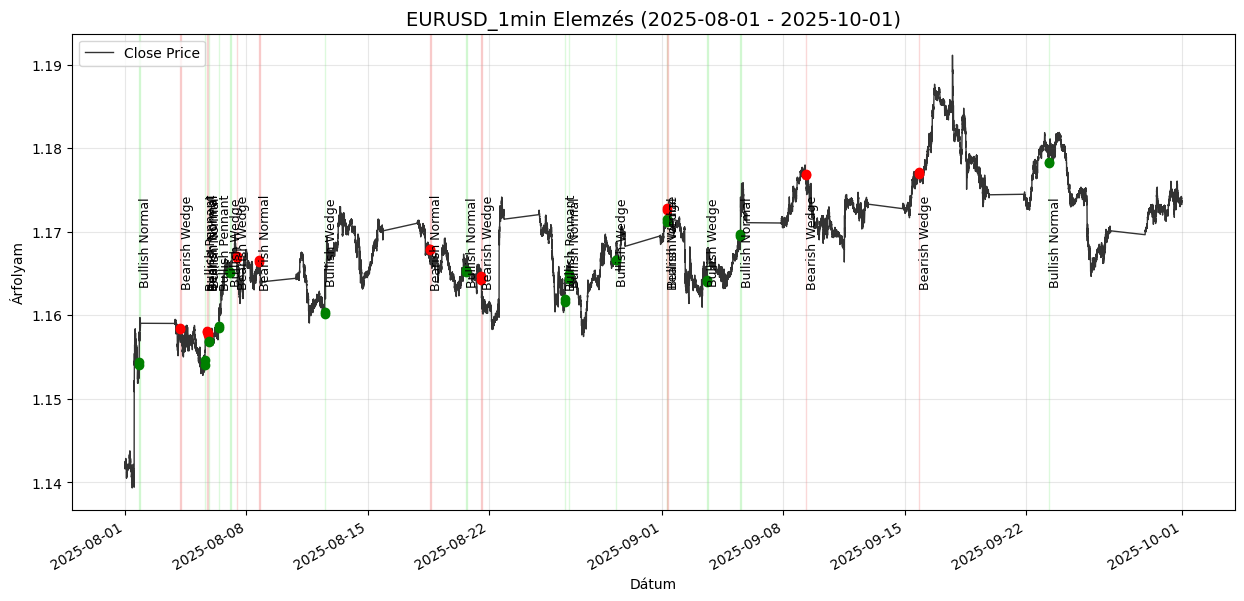

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# --- KONFIGURÁCIÓ ---
# Ha a Dockerben fut a Jupyter, akkor az útvonalak:
OUTPUT_DIR = './output'
LABELS_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# Melyik fájlt akarod látni? (Csak a név eleje kell, pl "EURUSD_1min")
TARGET_ASSET = "EURUSD_1min"

# Melyik időszakot?
START_DATE = '2025-08-01'
END_DATE = '2025-10-01'

def plot_interactive_chart():
    # 1. Címkék betöltése
    if not os.path.exists(LABELS_FILE):
        print("HIBA: Nincs ground_truth_labels.csv! Futtasd le a 01_data_processing.py-t.")
        return
    labels_df = pd.read_csv(LABELS_FILE)

    # 2. A megfelelő CSV megkeresése
    # A merged fájlok neve pl: merged_EURUSD_1min.csv
    csv_pattern = os.path.join(OUTPUT_DIR, f"merged_{TARGET_ASSET}*.csv")
    found_files = glob.glob(csv_pattern)

    if not found_files:
        print(f"HIBA: Nem találom a merged_{TARGET_ASSET}.csv fájlt az output mappában.")
        return

    csv_path = found_files[0]
    print(f"Adatok betöltése innen: {os.path.basename(csv_path)} ...")

    # 3. Adatok betöltése és szűrése
    try:
        df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
        # Szűrés időszakra
        mask = (df.index >= START_DATE) & (df.index <= END_DATE)
        df_subset = df.loc[mask]

        if df_subset.empty:
            print("Nincs adat ebben az időszakban.")
            return

    except Exception as e:
        print(f"Hiba a CSV olvasásakor: {e}")
        return

    # 4. Releváns címkék szűrése
    # A raw_csv_filename oszlopnak egyeznie kell a TARGET_ASSET-tel (pl. EURUSD_1min)
    file_labels = labels_df[labels_df['raw_csv_filename'] == TARGET_ASSET]

    # Dátum konverzió és szűrés
    file_labels['flag_start_ts'] = pd.to_datetime(file_labels['flag_start_ts'])
    file_labels['flag_end_ts'] = pd.to_datetime(file_labels['flag_end_ts'])

    visible_labels = file_labels[
        (file_labels['flag_start_ts'] >= START_DATE) &
        (file_labels['flag_start_ts'] <= END_DATE)
    ]

    print(f"Kirajzolás... ({len(visible_labels)} címke látható)")

    # --- PLOTTING (Inline) ---
    plt.figure(figsize=(15, 7))

    # Árfolyam
    plt.plot(df_subset.index, df_subset['close'], label='Close Price', color='#333333', linewidth=1)

    # Címkék
    for _, row in visible_labels.iterrows():
        color = 'green' if 'Bullish' in row['label'] else 'red'
        fill_color = 'lightgreen' if 'Bullish' in row['label'] else 'lightcoral'

        # Zászló Doboz (Flag)
        plt.axvspan(row['flag_start_ts'], row['flag_end_ts'], color=fill_color, alpha=0.3)

        # Rúd Vonal (Pole) - Ha sikerült kiszámolni
        if pd.notna(row['pole_start_ts']):
            pole_start = pd.to_datetime(row['pole_start_ts'])

            # Megpróbáljuk megkeresni az árakat a szebb vonalhoz
            try:
                # Nearest lookup a pandas indexben
                p1_idx = df.index.get_indexer([pole_start], method='nearest')[0]
                p2_idx = df.index.get_indexer([row['flag_start_ts']], method='nearest')[0]

                # Ár kiválasztása (Bullnál Low->High, Bearnél High->Low)
                if 'Bullish' in row['label']:
                    y1 = df.iloc[p1_idx]['low']  # Rúd alja
                    y2 = df.iloc[p2_idx]['high'] # Rúd teteje (Flag kezdete)
                else:
                    y1 = df.iloc[p1_idx]['high'] # Rúd teteje
                    y2 = df.iloc[p2_idx]['low']  # Rúd alja (Flag kezdete)

                # Vastag vonal a rúdtól a zászlóig
                plt.plot([pole_start, row['flag_start_ts']], [y1, y2],
                         color=color, linewidth=2.5, linestyle='-', marker='o')
            except:
                # Fallback: csak függőleges vonal, ha hiba van az árkeresésnél
                plt.axvline(pole_start, color=color, linestyle='--', alpha=0.5)

        # Felirat
        mid_point = row['flag_start_ts'] + (row['flag_end_ts'] - row['flag_start_ts']) / 2
        plt.text(mid_point, df_subset['close'].mean(), row['label'], rotation=90, verticalalignment='center', fontsize=9)

    plt.title(f"{TARGET_ASSET} Elemzés ({START_DATE} - {END_DATE})", fontsize=14)
    plt.xlabel("Dátum")
    plt.ylabel("Árfolyam")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')

    # Szép dátum formázás az X tengelyen
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    plt.show()

# Futtatás
plot_interactive_chart()

# Adatelokeszites

In [6]:
import os
import pandas as pd
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# --- KONFIGURÁCIÓ ---
# Dockerben:
OUTPUT_DIR = "./output"
# Lokális teszthez:
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"

LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# Modell paraméterek (csak az adat formázásához kellenek)
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4

# --- DATASET OSZTÁLY ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len

        # Cache a betöltött CSV-knek, hogy ne olvassuk be mindig újra
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # 1. A megfelelő MERGED CSV fájl neve
        # A 'raw_csv_filename' pl. 'EURUSD_5min'.
        # A fájl neve az output mappában: 'merged_EURUSD_5min.csv'
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        # 2. Betöltés (Cache-eléssel)
        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                    self.loaded_dfs[uniform_name] = df
                except Exception:
                    # Ha hiba van, üres DF-et teszünk be, hogy ne próbálkozzon újra
                    self.loaded_dfs[uniform_name] = None
            else:
                self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]

        # Ha nincs adat, dummy nullákat adunk vissza
        if df is None:
            return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(row['label_idx'])

        try:
            # 3. Szeletelés (Zászló + Rúd kivágása)
            # A pole_start_ts-t használjuk, amit az előző script számolt ki!
            # Ha esetleg nincs pole_start_ts, akkor a flag_start_ts-t használjuk fallbackként
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']

            s_time = pd.to_datetime(start_ts)
            e_time = pd.to_datetime(end_ts)

            # Kivágjuk az időablakot
            mask = (df.index >= s_time) & (df.index <= e_time)
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2:
                return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(row['label_idx'])

            # 4. Normalizálás (MinMax Scaling 0-1 közé)
            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)
            denom = seg_max - seg_min
            denom[denom == 0] = 1.0
            segment_norm = (segment - seg_min) / denom

            # 5. Interpoláció (Fix 50-es hosszra)
            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(
                tensor_segment, size=self.seq_len, mode='linear', align_corners=False
            )
            tensor_final = tensor_resized.squeeze(0).permute(1, 0) # [50, 4]

            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except Exception:
            return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(row['label_idx'])

# --- FŐ PROGRAM ---
def main():
    print(f"Adatok forrása: {OUTPUT_DIR}")

    # 1. Címkék betöltése
    if not os.path.exists(LABEL_FILE):
        print(f"HIBA: {LABEL_FILE} nem található. Futtasd le előbb a 01_data_processing.py-t!")
        return

    df_labels = pd.read_csv(LABEL_FILE)
    print(f"Összes címke: {len(df_labels)}")

    # 2. SZŰRÉS: Csak EURUSD és XAU (Gold)
    allowed_assets = ['EURUSD', 'XAU']

    # NaN szűrés
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])

    # Szűrő alkalmazása
    mask = df_labels['raw_csv_filename'].apply(
        lambda x: any(asset in str(x) for asset in allowed_assets)
    )
    df_filtered = df_labels[mask].reset_index(drop=True)

    print(f"Szűrt címkék (Csak EURUSD/XAU): {len(df_filtered)}")

    if df_filtered.empty:
        print("HIBA: A szűrés után nem maradt adat! Ellenőrizd a 'ground_truth_labels.csv'-t.")
        return

    # 3. Ellenőrizzük, hogy léteznek-e a merged CSV-k az outputban
    required_files = df_filtered['raw_csv_filename'].unique()
    print(f"Szükséges 'merged_' CSV fájlok száma: {len(required_files)}")

    missing_files = []
    for uname in required_files:
        path = os.path.join(OUTPUT_DIR, f"merged_{uname}.csv")
        if not os.path.exists(path):
            missing_files.append(f"merged_{uname}.csv")

    if missing_files:
        print(f"FIGYELEM: Hiányzó CSV fájlok az output mappából ({len(missing_files)} db):")
        print(missing_files[:5]) # Csak az első 5-öt írjuk ki
    else:
        print("Minden szükséges CSV fájl megtalálható az output mappában!")

    # 4. Címkék kódolása
    le = LabelEncoder()
    df_filtered['label_idx'] = le.fit_transform(df_filtered['label'])
    print(f"Osztályok: {le.classes_}")

    # 5. DataLoader Teszt
    # Itt adjuk át az OUTPUT_DIR-t, mint a CSV-k forrását
    dataset = FlagDataset(df_filtered, OUTPUT_DIR, seq_len=SEQUENCE_LENGTH)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    print("\nBatch készítése teszteléshez...")
    try:
        X_batch, y_batch = next(iter(loader))

        # Ellenőrzés: Ne legyen csupa nulla (ami a hibás betöltést jelzi)
        if X_batch.sum() == 0:
            print("\n[FIGYELEM] A Batch csupa nullát tartalmaz! Valami hiba történt a betöltésnél.")
        else:
            print("\n" + "="*40)
            print("SIKER! Az adatok betöltése az OUTPUT mappából működik.")
            print("="*40)
            print(f"Batch X Shape: {X_batch.shape}  (Batch, Seq, Features)")
            print(f"Batch y Shape: {y_batch.shape}")
            print("-" * 40)
            print("Minta adat (első elem):")
            print(X_batch[0][:5]) # Csak az első 5 sor
            print(f"\nMinta címke: {y_batch[0].item()} ({le.inverse_transform([y_batch[0].item()])[0]})")

    except StopIteration:
        print("HIBA: Az adatbetöltő üres.")
    except Exception as e:
        print(f"KRITIKUS HIBA: {e}")

if __name__ == "__main__":
    main()

Adatok forrása: ./output
Összes címke: 840
Szűrt címkék (Csak EURUSD/XAU): 840
Szükséges 'merged_' CSV fájlok száma: 12
Minden szükséges CSV fájl megtalálható az output mappában!
Osztályok: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Batch készítése teszteléshez...

SIKER! Az adatok betöltése az OUTPUT mappából működik.
Batch X Shape: torch.Size([32, 50, 4])  (Batch, Seq, Features)
Batch y Shape: torch.Size([32])
----------------------------------------
Minta adat (első elem):
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [0.9966, 0.9959, 0.9922, 0.9921],
        [0.8793, 0.8571, 0.7280, 0.7234],
        [0.7621, 0.7182, 0.4638, 0.4546],
        [0.6397, 0.5810, 0.2174, 0.2184]])

Minta címke: 0 (Bearish Normal)


In [7]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 0. GLOBÁLIS KONFIGURÁCIÓ
# ==========================================

# Útvonalak
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"
LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# Adat & Training Paraméterek
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
EPOCHS = 1000               # Felülírva a kérésed szerint
EARLY_STOPPING_PATIENCE = 10
LEARNING_RATE = 0.001
CLIP_VALUE = 1.0

# Modell Specifikus Paraméterek (LSTM Baseline)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2

# ==========================================
# 1. ADATELŐKÉSZÍTÉS (DATA PIPELINE)
# ==========================================

class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

def prepare_data(label_path, output_dir):
    """
    Betölti, szűri és előkészíti az adatokat.
    """
    print("\n[1] ADATELŐKÉSZÍTÉS...")
    if not os.path.exists(label_path):
        print(f"HIBA: {label_path} nem található.")
        return None

    df_labels = pd.read_csv(label_path)

    # Szűrés (EURUSD, XAU)
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    print(f"  -> Szűrt adatmennyiség: {len(df_labels)}")
    if len(df_labels) < 32: return None

    # Encoding
    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)

    # Split
    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # Class Weights
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # DataLoaders (Itt használjuk a globális BATCH_SIZE-t)
    train_loader = DataLoader(FlagDataset(train, output_dir), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(FlagDataset(val, output_dir), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, output_dir), batch_size=BATCH_SIZE, shuffle=False)

    print("  -> Adatok készen állnak.")
    return {
        'train': train_loader, 'val': val_loader, 'test': test_loader,
        'weights': class_weights, 'encoder': le, 'num_classes': num_classes
    }

# ==========================================
# 2. MODELL DEFINÍCIÓK (MODEL ZOO)
# ==========================================

class BaselineLSTM(nn.Module):
    """
    Baseline Model: Kétirányú LSTM.
    Ez használja a HIDDEN_SIZE és NUM_LAYERS globális paramétereket.
    """
    def __init__(self, input_size, num_classes):
        super(BaselineLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=HIDDEN_SIZE, # Globális
            num_layers=NUM_LAYERS,   # Globális
            batch_first=True,
            dropout=DROPOUT if NUM_LAYERS > 1 else 0, # Globális
            bidirectional=True
        )
        self.fc = nn.Linear(HIDDEN_SIZE * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]
        logits = self.fc(last_step_out)
        return logits

class ComplexModel(nn.Module):
    """
    HELY A KOMPLEX MODELLNEK (Transformer / Hybrid).
    Ide írhatod majd a bonyolultabb logikát.
    """
    def __init__(self, input_size, num_classes):
        super(ComplexModel, self).__init__()
        # TODO: Implementáció később
        pass

    def forward(self, x):
        pass

# ==========================================
# 3. TRÉNING MOTOR (GENERIC TRAINER)
# ==========================================

def train_engine(model, data_package, model_name="model"):
    """
    Általános tanító függvény.
    Használja: EPOCHS, LEARNING_RATE, CLIP_VALUE, EARLY_STOPPING_PATIENCE
    """
    print(f"\n[2] {model_name.upper()} TANÍTÁSA INDUL...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"  -> Eszköz: {device}")

    model = model.to(device)

    # Loss & Optimizer
    weights_tensor = torch.tensor(data_package['weights'], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Globális LR

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0 # Early Stopping számláló

    for epoch in range(EPOCHS): # Globális EPOCHS
        # Train
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X, y in data_package['train']:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()

            # Globális CLIP_VALUE
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        # Validation
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in data_package['val']:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        # Metrics
        avg_t_loss = train_loss / len(data_package['train'])
        avg_v_loss = val_loss / len(data_package['val'])
        t_acc = 100 * correct / total
        v_acc = 100 * v_correct / v_total

        scheduler.step(avg_v_loss)

        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Checkpointing
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            save_path = os.path.join(OUTPUT_DIR, f'{model_name}_best.pth')
            torch.save(model.state_dict(), save_path)

        # EARLY STOPPING LOGIKA
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\n[STOP] Early Stopping aktiválva {EARLY_STOPPING_PATIENCE} epoch után.")
                break

    print(f"\n[3] {model_name.upper()} KIÉRTÉKELÉS (TEST SET)")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f'{model_name}_best.pth'), weights_only=True))
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in data_package['test']:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=data_package['encoder'].classes_, zero_division=0))

# ==========================================
# 4. FŐ VEZÉRLŐK (RUNNERS)
# ==========================================

def run_baseline_model():
    """
    Hívja a Baseline (LSTM) modellt.
    """
    # 1. Adat
    data = prepare_data(LABEL_FILE, OUTPUT_DIR)
    if data is None: return

    # 2. Modell Inicializálás
    # Nem kell átadni a hidden_size-t, mert az osztály kiveszi a globálisból
    model = BaselineLSTM(
        input_size=INPUT_SIZE,
        num_classes=data['num_classes']
    )

    # 3. Tanítás
    train_engine(model, data, model_name="baseline_lstm")

def run_complex_model():
    """
    Hely a komplex modellnek.
    """
    print("A Complex Model implementációja még várat magára...")
    pass

# ==========================================
# MAIN ENTRY POINT
# ==========================================
if __name__ == "__main__":
    # Itt tudod váltogatni, mit futtatsz
    run_baseline_model()

    # run_complex_model()


[1] ADATELŐKÉSZÍTÉS...
  -> Szűrt adatmennyiség: 840
  -> Adatok készen állnak.

[2] BASELINE_LSTM TANÍTÁSA INDUL...
  -> Eszköz: cpu
Epoch 1/1000 | Loss: 1.7961/1.7862 | Acc: 11.2%/15.1% | LR: 0.001000
Epoch 2/1000 | Loss: 1.7855/1.7660 | Acc: 18.2%/26.2% | LR: 0.001000
Epoch 3/1000 | Loss: 1.7398/1.8027 | Acc: 21.1%/29.4% | LR: 0.001000
Epoch 4/1000 | Loss: 1.7254/1.7554 | Acc: 21.1%/16.7% | LR: 0.001000
Epoch 5/1000 | Loss: 1.6831/1.8037 | Acc: 16.3%/15.1% | LR: 0.001000
Epoch 6/1000 | Loss: 1.6890/1.6807 | Acc: 23.0%/31.7% | LR: 0.001000
Epoch 7/1000 | Loss: 1.6706/1.7029 | Acc: 28.1%/18.3% | LR: 0.001000
Epoch 8/1000 | Loss: 1.6811/1.7245 | Acc: 26.7%/26.2% | LR: 0.001000
Epoch 9/1000 | Loss: 1.6693/1.6988 | Acc: 25.7%/20.6% | LR: 0.001000
Epoch 10/1000 | Loss: 1.6745/1.6795 | Acc: 25.9%/27.0% | LR: 0.001000
Epoch 11/1000 | Loss: 1.6378/1.7004 | Acc: 27.7%/25.4% | LR: 0.001000
Epoch 12/1000 | Loss: 1.6404/1.6616 | Acc: 28.7%/25.4% | LR: 0.001000
Epoch 13/1000 | Loss: 1.6213/1.667

# Baseline model

In [42]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"

LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK ---
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 30
CLIP_VALUE = 1.0    # ÚJ: Gradiens vágás értéke (Critical for LSTM)

# --- 1. DATASET OSZTÁLY (Biztonságosabb) ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except:
                    self.loaded_dfs[uniform_name] = None
            else:
                self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']

            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            # --- JAVÍTÁS 1: Biztonságos Normalizálás ---
            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)

            # Hozzáadunk egy pici számot (1e-6), hogy sose osszunk nullával
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom

            # --- JAVÍTÁS 2: NaN ellenőrzés ---
            # Ha bármi NaN lett (pl. végtelen adat miatt), cseréljük nullára
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(
                tensor_segment, size=self.seq_len, mode='linear', align_corners=False
            )
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            # Végső ellenőrzés: ha még mindig van NaN a tensorban
            if torch.isnan(tensor_final).any():
                return self._get_dummy()

            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except Exception:
            return self._get_dummy()

    def _get_dummy(self):
        # Biztonsági kimenet hiba esetén
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL ---
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=DROPOUT if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]
        logits = self.fc(last_step_out)
        return logits

# --- 3. MAIN ---
def main():
    print("--- BASELINE MODEL TRAINING (LSTM 2-Layer) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    if not os.path.exists(LABEL_FILE):
        print(f"HIBA: {LABEL_FILE} nem található.")
        return
    df_labels = pd.read_csv(LABEL_FILE)

    # Szűrés
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)
    print(f"Adatok száma: {len(df_labels)}")

    if len(df_labels) < 10:
        print("Túl kevés adat!")
        return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    print(f"Osztályok: {le.classes_}")
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    # Split
    train_val_df, test_df = train_test_split(
        df_labels, test_size=0.15, random_state=42, stratify=df_labels['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['label']
    )

    # DataLoaders
    train_ds = FlagDataset(train_df, OUTPUT_DIR, SEQUENCE_LENGTH)
    val_ds = FlagDataset(val_df, OUTPUT_DIR, SEQUENCE_LENGTH)
    test_ds = FlagDataset(test_df, OUTPUT_DIR, SEQUENCE_LENGTH)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Init
    model = BaselineLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nIndul a tanítás...")
    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()

            # --- JAVÍTÁS 3: GRADIENT CLIPPING ---
            # Ez akadályozza meg, hogy a Loss NaN legyen!
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        train_acc = 100 * correct / total if total > 0 else 0
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.1f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.1f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'baseline_model.pth'))

    # Final Test
    print("\n--- VÉGSŐ TESZT ---")
    if os.path.exists(os.path.join(OUTPUT_DIR, 'baseline_model.pth')):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'baseline_model.pth'), weights_only=True))

    model.eval()
    test_correct = 0
    test_total = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(f"Teszt Pontosság: {100 * test_correct / test_total:.2f}%")
    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

--- BASELINE MODEL TRAINING (LSTM 2-Layer) - JAVÍTOTT ---
Device: cpu
Adatok száma: 966
Osztályok: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Indul a tanítás...
Epoch 1/30 | Train Loss: 1.7790 Acc: 24.4% | Val Loss: 1.7119 Acc: 24.8%
Epoch 2/30 | Train Loss: 1.7085 Acc: 24.6% | Val Loss: 1.6965 Acc: 31.0%
Epoch 3/30 | Train Loss: 1.6953 Acc: 32.5% | Val Loss: 1.6629 Acc: 33.8%
Epoch 4/30 | Train Loss: 1.6313 Acc: 35.9% | Val Loss: 1.6441 Acc: 33.8%
Epoch 5/30 | Train Loss: 1.6116 Acc: 35.4% | Val Loss: 1.5850 Acc: 33.1%
Epoch 6/30 | Train Loss: 1.5947 Acc: 36.5% | Val Loss: 1.6543 Acc: 33.1%
Epoch 7/30 | Train Loss: 1.5855 Acc: 36.8% | Val Loss: 1.5655 Acc: 34.5%
Epoch 8/30 | Train Loss: 1.5848 Acc: 35.8% | Val Loss: 1.5735 Acc: 33.1%
Epoch 9/30 | Train Loss: 1.5767 Acc: 38.0% | Val Loss: 1.5710 Acc: 34.5%
Epoch 10/30 | Train Loss: 1.5618 Acc: 38.8% | Val Loss: 1.5516 Acc: 33.1%
Epoch 11/30 | Train Loss: 1.5396 Acc: 38.9% |

--- BASELINE MODEL TRAINING (LSTM 2-Layer) ---
Device: cpu
Adatok száma: 841
Osztályok: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Indul a tanítás...
Epoch 1/30 | Train Loss: 1.7742 Acc: 23.0% | Val Loss: 1.7284 Acc: 26.2%
Epoch 2/30 | Train Loss: 1.7220 Acc: 26.0% | Val Loss: 1.7006 Acc: 29.4%
Epoch 3/30 | Train Loss: 1.6983 Acc: 29.4% | Val Loss: 1.6986 Acc: 28.6%
Epoch 4/30 | Train Loss: 1.6916 Acc: 28.9% | Val Loss: 1.6888 Acc: 33.3%
Epoch 5/30 | Train Loss: 1.6866 Acc: 30.8% | Val Loss: 1.6245 Acc: 37.3%
Epoch 6/30 | Train Loss: 1.6184 Acc: 35.5% | Val Loss: 1.5635 Acc: 38.9%
Epoch 7/30 | Train Loss: 1.6159 Acc: 37.4% | Val Loss: 1.5596 Acc: 39.7%
Epoch 8/30 | Train Loss: 1.6074 Acc: 35.9% | Val Loss: 1.5443 Acc: 39.7%
Epoch 9/30 | Train Loss: 1.6038 Acc: 37.2% | Val Loss: 1.5702 Acc: 36.5%
Epoch 10/30 | Train Loss: 1.6175 Acc: 35.7% | Val Loss: 1.5944 Acc: 35.7%
Epoch 11/30 | Train Loss: 1.5906 Acc: 37.6% | Val Loss: 

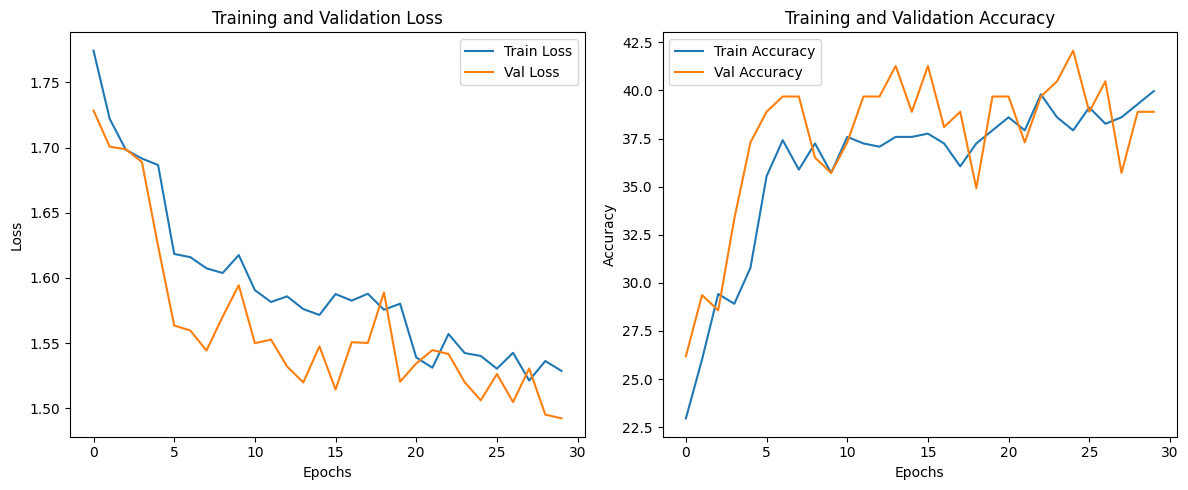


--- VÉGSŐ TESZT ---
Teszt Pontosság: 37.80%
                 precision    recall  f1-score   support

 Bearish Normal       0.39      0.63      0.48        35
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.00      0.00      0.00        17
 Bullish Normal       0.38      0.79      0.51        33
Bullish Pennant       0.00      0.00      0.00        14
  Bullish Wedge       0.00      0.00      0.00        18

       accuracy                           0.38       127
      macro avg       0.13      0.24      0.17       127
   weighted avg       0.21      0.38      0.27       127



In [47]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt # Import plotting library

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"

LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK ---
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 30
CLIP_VALUE = 1.0    # ÚJ: Gradiens vágás értéke (Critical for LSTM)

# --- 1. DATASET OSZTÁLY (Biztonságosabb) ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except:
                    self.loaded_dfs[uniform_name] = None
            else:
                self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']

            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            # --- JAVÍTÁS 1: Biztonságos Normalizálás ---
            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)

            # Hozzáadunk egy pici számot (1e-6), hogy sose osszunk nullával
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom

            # --- JAVÍTÁS 2: NaN ellenőrzés ---
            # Ha bármi NaN lett (pl. végtelen adat miatt), cseréljük nullára
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(
                tensor_segment, size=self.seq_len, mode='linear', align_corners=False
            )
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            # Végső ellenőrzés: ha még mindig van NaN a tensorban
            if torch.isnan(tensor_final).any():
                return self._get_dummy()

            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except Exception:
            return self._get_dummy()

    def _get_dummy(self):
        # Biztonsági kimenet hiba esetén
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL ---
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=DROPOUT if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]
        logits = self.fc(last_step_out)
        return logits

# --- 3. MAIN ---
def main():
    print("--- BASELINE MODEL TRAINING (LSTM 2-Layer) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    if not os.path.exists(LABEL_FILE):
        print(f"HIBA: {LABEL_FILE} nem található.")
        return
    df_labels = pd.read_csv(LABEL_FILE)

    # Szűrés
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)
    print(f"Adatok száma: {len(df_labels)}")

    if len(df_labels) < 10:
        print("Túl kevés adat!")
        return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    print(f"Osztályok: {le.classes_}")
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    # Split
    train_val_df, test_df = train_test_split(
        df_labels, test_size=0.15, random_state=42, stratify=df_labels['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['label']
    )

    # DataLoaders
    train_ds = FlagDataset(train_df, OUTPUT_DIR, SEQUENCE_LENGTH)
    val_ds = FlagDataset(val_df, OUTPUT_DIR, SEQUENCE_LENGTH)
    test_ds = FlagDataset(test_df, OUTPUT_DIR, SEQUENCE_LENGTH)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Init
    model = BaselineLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nIndul a tanítás...")
    best_val_acc = 0.0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()

            # --- JAVÍTÁS 3: GRADIENT CLIPPING ---
            # Ez akadályozza meg, hogy a Loss NaN legyen!
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        train_acc = 100 * correct / total if total > 0 else 0
        avg_train_loss = train_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.1f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.1f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'baseline_model.pth'))

    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show() # Display plot in notebook context or save to file if run as script

    # Final Test
    print("\n--- VÉGSŐ TESZT ---")
    if os.path.exists(os.path.join(OUTPUT_DIR, 'baseline_model.pth')):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'baseline_model.pth'), weights_only=True))

    model.eval()
    test_correct = 0
    test_total = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(f"Teszt Pontosság: {100 * test_correct / test_total:.2f}%")
    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

In [48]:
# Lathato hogy csak a normal alakzatokra tanul ra, hiszen ezekbol a tanito adatokbol tobb van, igy nem erdemes mast "tippelnie"

--- BASELINE MODEL (Súlyozott Loss) ---
Device: cpu

Osztálysúlyok számítása...
Súlyok (Ritkább osztály = Nagyobb szám):
  Bearish Normal: 0.6164
  Bearish Pennant: 2.1778
  Bearish Wedge: 1.2405
  Bullish Normal: 0.6405
  Bullish Pennant: 1.4848
  Bullish Wedge: 1.1395

TANÍTÁS INDUL...
Epoch 1/30 | Train Loss: 1.7938 Acc: 14.6% | Val Loss: 1.7869 Acc: 14.3%
Epoch 2/30 | Train Loss: 1.7848 Acc: 19.0% | Val Loss: 1.7612 Acc: 25.4%
Epoch 3/30 | Train Loss: 1.7603 Acc: 22.6% | Val Loss: 1.6941 Acc: 28.6%
Epoch 4/30 | Train Loss: 1.7099 Acc: 29.6% | Val Loss: 1.6449 Acc: 33.3%
Epoch 5/30 | Train Loss: 1.7052 Acc: 28.6% | Val Loss: 1.7426 Acc: 27.0%
Epoch 6/30 | Train Loss: 1.7157 Acc: 28.4% | Val Loss: 1.6456 Acc: 34.1%
Epoch 7/30 | Train Loss: 1.6727 Acc: 28.9% | Val Loss: 1.6547 Acc: 28.6%
Epoch 8/30 | Train Loss: 1.7181 Acc: 26.7% | Val Loss: 1.6338 Acc: 33.3%
Epoch 9/30 | Train Loss: 1.6836 Acc: 31.0% | Val Loss: 1.6815 Acc: 27.8%
Epoch 10/30 | Train Loss: 1.6859 Acc: 28.2% | Val Loss

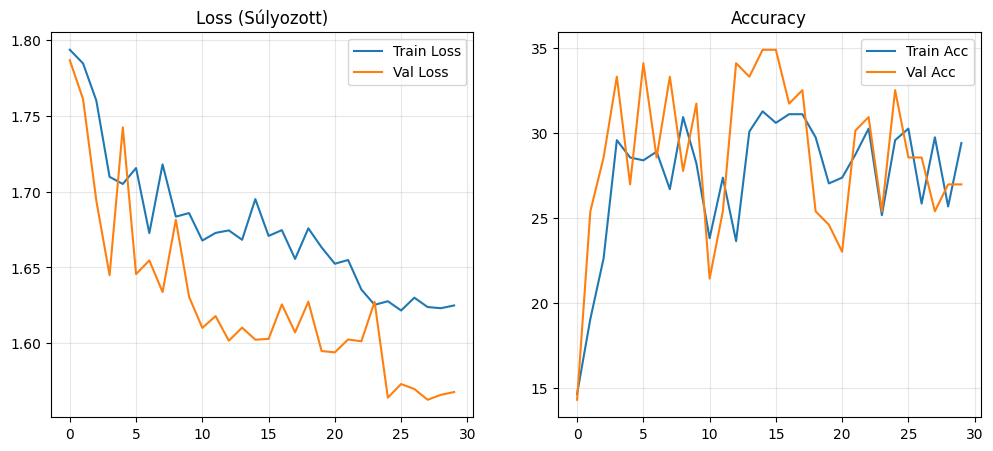


--- VÉGSŐ TESZT ---
Teszt Pontosság: 29.13%
                 precision    recall  f1-score   support

 Bearish Normal       0.38      0.77      0.50        35
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.00      0.00      0.00        17
 Bullish Normal       0.00      0.00      0.00        33
Bullish Pennant       0.23      0.71      0.34        14
  Bullish Wedge       0.00      0.00      0.00        18

       accuracy                           0.29       127
      macro avg       0.10      0.25      0.14       127
   weighted avg       0.13      0.29      0.18       127



In [49]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight # --- ÚJ IMPORT ---
import matplotlib.pyplot as plt

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"

LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK ---
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 30
CLIP_VALUE = 1.0

# --- 1. DATASET OSZTÁLY (Változatlan) ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except:
                    self.loaded_dfs[uniform_name] = None
            else:
                self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(
                tensor_segment, size=self.seq_len, mode='linear', align_corners=False
            )
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()

            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except Exception:
            return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL (Változatlan) ---
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=DROPOUT if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]
        logits = self.fc(last_step_out)
        return logits

# --- 3. MAIN ---
def main():
    print("--- BASELINE MODEL (Súlyozott Loss) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    if not os.path.exists(LABEL_FILE):
        print(f"HIBA: {LABEL_FILE} nem található.")
        return
    df_labels = pd.read_csv(LABEL_FILE)

    # Szűrés
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    if len(df_labels) < 10:
        print("Túl kevés adat!")
        return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    # Split (Stratified - ez is fontos az egyensúlyhoz!)
    train_val_df, test_df = train_test_split(
        df_labels, test_size=0.15, random_state=42, stratify=df_labels['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['label']
    )

    # --- ÚJ: SÚLYOK KISZÁMÍTÁSA ---
    print("\nOsztálysúlyok számítása...")
    # Csak a Train halmazon számoljuk, hogy ne 'lesse meg' a tesztet
    train_labels = train_df['label_idx'].values

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )

    # Tensorrá konvertálás és GPU-ra tétel
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    print("Súlyok (Ritkább osztály = Nagyobb szám):")
    for cls, weight in zip(le.classes_, class_weights):
        print(f"  {cls}: {weight:.4f}")
    # -----------------------------

    train_loader = DataLoader(FlagDataset(train_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(FlagDataset(val_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)

    model = BaselineLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, num_classes).to(device)

    # --- ÚJ: A Loss függvény megkapja a súlyokat ---
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # History
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print("\nTANÍTÁS INDUL...")
    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.1f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.1f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'baseline_model.pth'))

    # Vizualizáció
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss (Súlyozott)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Végső Teszt
    print("\n--- VÉGSŐ TESZT ---")
    if os.path.exists(os.path.join(OUTPUT_DIR, 'baseline_model.pth')):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'baseline_model.pth'), weights_only=True))

    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(f"Teszt Pontosság: {100 * test_correct / test_total:.2f}%")
    # Itt fogod látni, hogy a 'Pennant' típusoknál javult-e a felismerés
    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

--- TURBÓZOTT BASELINE (Bi-LSTM + Scheduler) ---
Device: cpu

Osztálysúlyok:
  Bearish Normal: 0.61
  Bearish Pennant: 2.18
  Bearish Wedge: 1.24
  Bullish Normal: 0.64
  Bullish Pennant: 1.48
  Bullish Wedge: 1.14

Tanítás indul...
Epoch 1/50 | Loss: 1.7945 / 1.7820 | Acc: 19.6% / 28.6% | LR: 0.001000
Epoch 2/50 | Loss: 1.7701 / 1.7363 | Acc: 19.6% / 24.6% | LR: 0.001000
Epoch 3/50 | Loss: 1.7304 / 1.7109 | Acc: 24.5% / 17.5% | LR: 0.001000
Epoch 4/50 | Loss: 1.7001 / 1.6917 | Acc: 24.1% / 27.8% | LR: 0.001000
Epoch 5/50 | Loss: 1.7104 / 1.6642 | Acc: 26.5% / 17.5% | LR: 0.001000
Epoch 6/50 | Loss: 1.6761 / 1.6609 | Acc: 22.6% / 19.8% | LR: 0.001000
Epoch 7/50 | Loss: 1.6707 / 1.6766 | Acc: 23.6% / 27.0% | LR: 0.001000
Epoch 8/50 | Loss: 1.6519 / 1.7166 | Acc: 24.5% / 23.0% | LR: 0.001000
Epoch 9/50 | Loss: 1.6658 / 1.6593 | Acc: 32.1% / 31.7% | LR: 0.001000
Epoch 10/50 | Loss: 1.6437 / 1.6756 | Acc: 30.4% / 30.2% | LR: 0.001000
Epoch 11/50 | Loss: 1.6895 / 1.6687 | Acc: 26.2% / 20.6%

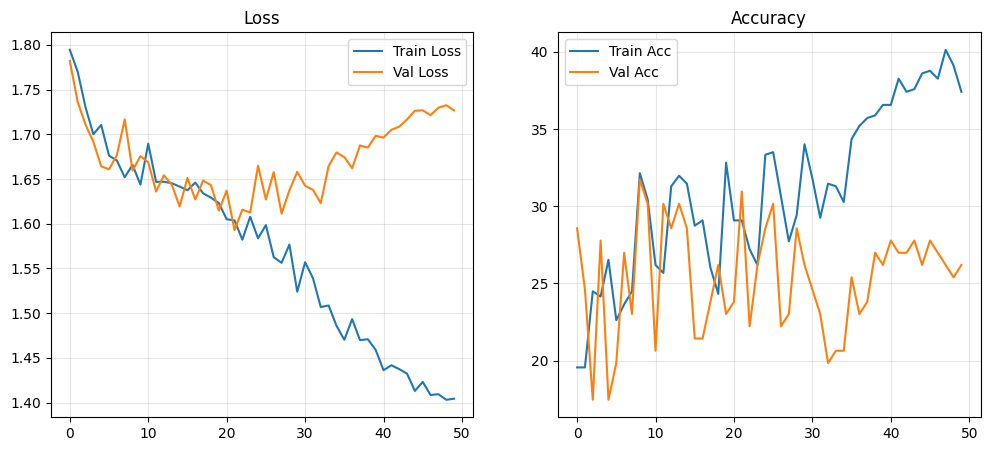


--- VÉGSŐ TESZT ---
Teszt Pontosság: 33.33%
                 precision    recall  f1-score   support

 Bearish Normal       0.39      0.71      0.50        34
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.33      0.12      0.17        17
 Bullish Normal       0.28      0.15      0.20        33
Bullish Pennant       0.26      0.64      0.38        14
  Bullish Wedge       0.40      0.11      0.17        18

       accuracy                           0.33       126
      macro avg       0.28      0.29      0.24       126
   weighted avg       0.31      0.33      0.28       126



In [55]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"

LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK ---
BATCH_SIZE = 32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
HIDDEN_SIZE = 128   # 128 neuron
NUM_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
EPOCHS = 50
CLIP_VALUE = 1.0

# --- 1. DATASET OSZTÁLY ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except:
                    self.loaded_dfs[uniform_name] = None
            else:
                self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(
                tensor_segment, size=self.seq_len, mode='linear', align_corners=False
            )
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()

            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except Exception:
            return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL: BIDIRECTIONAL LSTM ---
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BaselineLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=DROPOUT if num_layers > 1 else 0,
            bidirectional=True
        )

        # Bidirectional -> Hidden size * 2
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]
        logits = self.fc(last_step_out)
        return logits

# --- 3. MAIN ---
def main():
    print("--- TURBÓZOTT BASELINE (Bi-LSTM + Scheduler) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    if not os.path.exists(LABEL_FILE):
        print("HIBA: Nincs adat.")
        return
    df_labels = pd.read_csv(LABEL_FILE)

    # Szűrés
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    if len(df_labels) < 10:
        print("Túl kevés adat!")
        return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    train_val_df, test_df = train_test_split(
        df_labels, test_size=0.15, random_state=42, stratify=df_labels['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['label']
    )

    # Súlyozott Loss
    print("\nOsztálysúlyok:")
    train_labels = train_df['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    for cls, w in zip(le.classes_, class_weights):
        print(f"  {cls}: {w:.2f}")

    train_loader = DataLoader(FlagDataset(train_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(FlagDataset(val_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test_df, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)

    model = BaselineLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- JAVÍTOTT SCHEDULER (verbose nélkül) ---
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print("\nTanítás indul...")
    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        scheduler.step(avg_val_loss)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Kézzel íratjuk ki az LR-t
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} / {avg_val_loss:.4f} | Acc: {train_acc:.1f}% / {val_acc:.1f}% | LR: {current_lr:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'baseline_model.pth'))

    # Vizualizáció
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Final Test
    print("\n--- VÉGSŐ TESZT ---")
    if os.path.exists(os.path.join(OUTPUT_DIR, 'baseline_model.pth')):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'baseline_model.pth'), weights_only=True))

    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(f"Teszt Pontosság: {100 * test_correct / test_total:.2f}%")
    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

# Model developement

In [55]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "./output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"
LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK ---
BATCH_SIZE = 64 #32
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
D_MODEL = 128
NUM_HEADS = 8 #4
NUM_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.4 #0.3
LEARNING_RATE = 0.0005
EPOCHS = 100            # Megemeljük, mert az Early Stopping úgyis leállítja időben!
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 15  # ÚJ: Ha 15 epochig nem javul a Loss, STOP.

# --- 1. DATASET ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try:
                    self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min, seg_max = segment.min(axis=0), segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL KOMPONENSEK ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class FlagTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout):
        super().__init__()
        self.input_embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=SEQUENCE_LENGTH)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.input_embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        logits = self.fc_out(x)
        return logits

# --- 3. MAIN ---
def main():
    print("--- FLAG TRANSFORMER (Early Stopping Enabled) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Eszköz: {device}")

    if not os.path.exists(LABEL_FILE):
        print(f"HIBA: {LABEL_FILE} nem található.")
        return
    df_labels = pd.read_csv(LABEL_FILE)

    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    if len(df_labels) < 32:
        print("Túl kevés adat!")
        return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_loader = DataLoader(FlagDataset(train, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(FlagDataset(val, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)

    model = FlagTransformer(
        input_size=INPUT_SIZE, num_classes=num_classes, d_model=D_MODEL,
        nhead=NUM_HEADS, num_layers=NUM_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    print("\nTanítás indul...")

    # --- ÁLLAPOT VÁLTOZÓK ---
    best_val_acc = 0.0
    best_val_loss = float('inf')  # Early Stoppinghoz
    patience_counter = 0          # Számláló

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        # Scheduler Step
        scheduler.step(avg_v_loss)

        # Logolás
        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}% | LR: {lr:.6f}")

        # --- MODEL MENTÉS (Legjobb Accuracy) ---
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'transformer_model.pth'))
            # print("  [SAVE] Új legjobb Accuracy!")

        # --- EARLY STOPPING LOGIKA (Validation Loss alapján) ---
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0 # Reseteljük a számlálót, mert javultunk
        else:
            patience_counter += 1
            # print(f"  [ES] Türelem: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\n[STOP] Early Stopping aktiválva! A hiba nem csökkent {EARLY_STOPPING_PATIENCE} epoch óta.")
                break

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # Final Test
    print("\n--- TEST SET KIÉRTÉKELÉS ---")
    if os.path.exists(os.path.join(OUTPUT_DIR, 'transformer_model.pth')):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'transformer_model.pth'), weights_only=True))
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

--- TRANSFORMER V2 (Optimized) ---
Eszköz: cpu

TANÍTÁS INDUL...


/home/bence/PycharmProjects/Melytanulas/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100 | Loss: 1.8662/1.8267 | Acc: 16.5%/15.1% | LR: 0.000043
Epoch 2/100 | Loss: 1.8470/1.8134 | Acc: 18.1%/15.9% | LR: 0.000051
Epoch 3/100 | Loss: 1.8260/1.7992 | Acc: 18.1%/17.5% | LR: 0.000064
Epoch 4/100 | Loss: 1.8294/1.7833 | Acc: 19.4%/20.6% | LR: 0.000082
Epoch 5/100 | Loss: 1.7998/1.7678 | Acc: 19.4%/20.6% | LR: 0.000105
Epoch 6/100 | Loss: 1.7771/1.7527 | Acc: 20.7%/22.2% | LR: 0.000132
Epoch 7/100 | Loss: 1.7580/1.7395 | Acc: 21.5%/20.6% | LR: 0.000164
Epoch 8/100 | Loss: 1.7519/1.7281 | Acc: 20.5%/17.5% | LR: 0.000200
Epoch 9/100 | Loss: 1.7335/1.7208 | Acc: 22.0%/25.4% | LR: 0.000239
Epoch 10/100 | Loss: 1.7352/1.7139 | Acc: 24.3%/28.6% | LR: 0.000282
Epoch 11/100 | Loss: 1.7186/1.7124 | Acc: 24.5%/29.4% | LR: 0.000327
Epoch 12/100 | Loss: 1.7223/1.7083 | Acc: 26.0%/31.7% | LR: 0.000374
Epoch 13/100 | Loss: 1.7267/1.6951 | Acc: 25.5%/31.0% | LR: 0.000423
Epoch 14/100 | Loss: 1.7179/1.6945 | Acc: 23.4%/30.2% | LR: 0.000472
Epoch 15/100 | Loss: 1.6959/1.7046 | Acc: 2

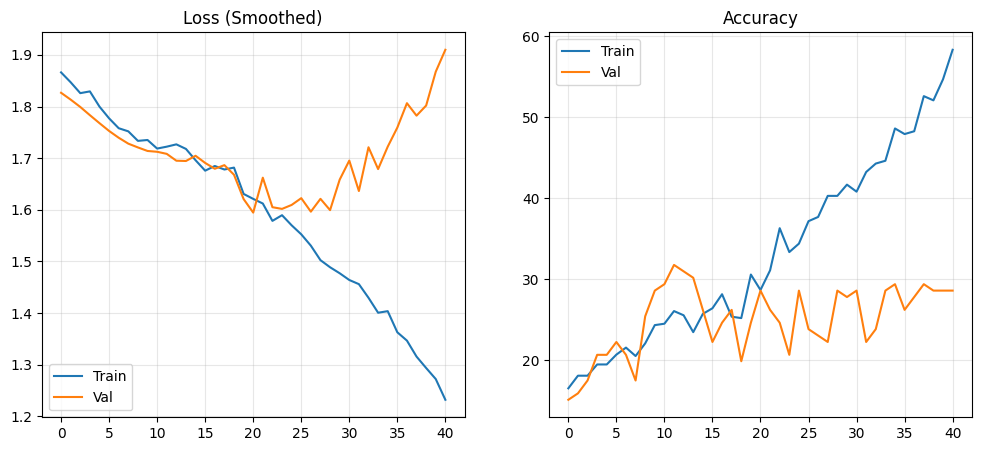


--- TEST SET ---
                 precision    recall  f1-score   support

 Bearish Normal       0.37      0.32      0.34        34
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.21      0.24      0.22        17
 Bullish Normal       0.00      0.00      0.00        33
Bullish Pennant       0.21      0.64      0.32        14
  Bullish Wedge       0.19      0.22      0.21        18

       accuracy                           0.22       126
      macro avg       0.16      0.24      0.18       126
   weighted avg       0.18      0.22      0.19       126



In [58]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "./output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"
LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- OPTIMALIZÁLT HIPERPARAMÉTEREK ---
BATCH_SIZE = 64         # Növelve: Stabilabb gradiens
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
D_MODEL = 64            # Csökkentve: Kisebb modell (kevés adat miatt)
NUM_HEADS = 8           # Növelve: Több figyelem (Attention)
NUM_LAYERS = 4          # Mélyebb, de keskenyebb háló
DIM_FEEDFORWARD = 128   # Kisebb belső háló
DROPOUT = 0.4           # Agresszívabb regularizáció
LEARNING_RATE = 0.001   # OneCycleLR majd kezeli
EPOCHS = 100
WEIGHT_DECAY = 1e-3     # Erősebb súly-büntetés
PATIENCE = 20           # Early Stopping türelem

# --- 1. DATASET (Változatlan) ---
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min, seg_max = segment.min(axis=0), segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# --- 2. MODELL: POSITIONAL ENCODING ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# --- 3. MODELL: FLAG TRANSFORMER (Kisebb, de fókuszáltabb) ---
class FlagTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout):
        super().__init__()

        self.input_embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=SEQUENCE_LENGTH)

        # Batch Normalization az elején segíthet stabilizálni
        self.bn_input = nn.BatchNorm1d(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True # Fontos: Pre-LayerNorm a stabilabb konvergenciáért
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(), # ReLU helyett GELU (modernebb)
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [Batch, Seq, 4]
        x = self.input_embedding(x) # -> [Batch, Seq, D_Model]
        x = self.pos_encoder(x)

        # BN (Permute needed: BN expects [Batch, Feature, Seq])
        x = x.permute(0, 2, 1)
        x = self.bn_input(x)
        x = x.permute(0, 2, 1)

        x = self.transformer_encoder(x)
        x = x.mean(dim=1) # Global Average Pooling
        logits = self.fc_out(x)
        return logits

# --- 4. MAIN ---
def main():
    print("--- TRANSFORMER V2 (Optimized) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Eszköz: {device}")

    # Adat
    if not os.path.exists(LABEL_FILE): return
    df_labels = pd.read_csv(LABEL_FILE)

    # Szűrés
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    if len(df_labels) < 32: return

    # Encode & Split
    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # Loaders
    train_loader = DataLoader(FlagDataset(train, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=True, drop_last=True) # Drop last a stabil batchnorm miatt
    val_loader = DataLoader(FlagDataset(val, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, OUTPUT_DIR), batch_size=BATCH_SIZE, shuffle=False)

    # Class Weights
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Modell
    model = FlagTransformer(
        input_size=INPUT_SIZE, num_classes=num_classes, d_model=D_MODEL,
        nhead=NUM_HEADS, num_layers=NUM_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # --- ÚJ: Label Smoothing ---
    # Ez segít, hogy ne legyen "túl biztos" a dolgában, így jobban általánosít
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

    # --- ÚJ: OneCycleLR Scheduler ---
    # Ez a modern "bemelegítés + lehűtés" technika. Sokkal jobb, mint a sima ReduceOnPlateau.
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader)
    )

    print("\nTANÍTÁS INDUL...")
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step() # Minden batch után léptetjük!

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Model Checkpointing
        if v_acc >= best_val_acc: # >= hogy azonosnál is mentsen
            best_val_acc = v_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'transformer_model_v2.pth'))

        # Early Stopping (Loss alapján)
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"[STOP] Early Stopping: {PATIENCE} epoch óta nem javul a Loss.")
                break

    # Vizualizáció
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss (Smoothed)')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # Végső Teszt
    print("\n--- TEST SET ---")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'transformer_model_v2.pth'), weights_only=True))
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    main()

In [59]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# ==========================================
# 1. CLASSES (Dataset & Model Components)
# ==========================================

class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min, seg_max = segment.min(axis=0), segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32).permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, 4)), torch.tensor(0, dtype=torch.long) # Fixed input size 4 for dummy

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class FlagTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, seq_len):
        super().__init__()

        self.input_embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        self.bn_input = nn.BatchNorm1d(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [Batch, Seq, Input_Size]
        x = self.input_embedding(x)
        x = self.pos_encoder(x)

        x = x.permute(0, 2, 1)
        x = self.bn_input(x)
        x = x.permute(0, 2, 1)

        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        logits = self.fc_out(x)
        return logits

# ==========================================
# 2. TRAINING FUNCTION (Callable)
# ==========================================

def train_transformer_model(
    # --- Configuration ---
    output_dir="./output",          # Path to output directory containing data
    label_file="ground_truth_labels.csv", # Name of the label file

    # --- Hyperparameters ---
    batch_size=64,
    sequence_length=50,
    input_size=4,
    d_model=64,
    num_heads=8,
    num_layers=4,
    dim_feedforward=128,
    dropout=0.4,
    learning_rate=0.001,
    epochs=100,
    weight_decay=1e-3,
    patience=20,

    # --- System ---
    device=None # Auto-detect if None
):
    """
    Trains the FlagTransformer model with the given hyperparameters.
    """

    # 1. Setup
    print(f"\n--- STARTING TRAINING ---")
    print(f"Config: D_Model={d_model}, Layers={num_layers}, Heads={num_heads}, Batch={batch_size}, LR={learning_rate}")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_label_path = os.path.join(output_dir, label_file)
    if not os.path.exists(full_label_path):
        print(f"ERROR: Label file not found at {full_label_path}")
        return None

    # 2. Load and Filter Data
    df_labels = pd.read_csv(full_label_path)
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    print(f"Total samples after filtering: {len(df_labels)}")
    if len(df_labels) < 32:
        print("Error: Not enough data points.")
        return None

    # 3. Encoding & Splitting
    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)

    # Save classes for inference later
    np.save(os.path.join(output_dir, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # 4. Class Weights
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # 5. DataLoaders
    train_loader = DataLoader(FlagDataset(train, output_dir, sequence_length), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(FlagDataset(val, output_dir, sequence_length), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, output_dir, sequence_length), batch_size=batch_size, shuffle=False)

    # 6. Model Initialization
    model = FlagTransformer(
        input_size=input_size, num_classes=num_classes, d_model=d_model,
        nhead=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward,
        dropout=dropout, seq_len=sequence_length
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    # 7. Training Loop
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Checkpointing
        if v_acc >= best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), os.path.join(output_dir, 'transformer_model_v2.pth'))

        # Early Stopping
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[STOP] Early Stopping triggered after {patience} epochs of no loss improvement.")
                break

    # 8. Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # 9. Final Evaluation
    print("\n--- FINAL TEST EVALUATION ---")
    model.load_state_dict(torch.load(os.path.join(output_dir, 'transformer_model_v2.pth'), weights_only=True))
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    report = classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0)
    print(report)

    return history, report

In [ ]:
if __name__ == "__main__":
    # Determine default paths based on environment
    DEFAULT_OUTPUT_DIR = "./output"

    # You can now call the function with your desired parameters
    train_transformer_model(
        output_dir=DEFAULT_OUTPUT_DIR,
        batch_size=64,
        d_model=64,
        num_heads=8,
        num_layers=4,
        dropout=0.4,
        epochs=100,
        patience=20
    )

# With data augmentation:


--- STARTING TRAINING V3 (Augmentation + Small Model) ---
Device: cpu


/home/bence/PycharmProjects/Melytanulas/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100 | Loss: 1.8289/1.8238 | Acc: 18.2%/15.1%
Epoch 2/100 | Loss: 1.8293/1.8211 | Acc: 15.8%/16.7%
Epoch 3/100 | Loss: 1.8330/1.8185 | Acc: 16.3%/17.5%
Epoch 4/100 | Loss: 1.8230/1.8156 | Acc: 15.3%/19.0%
Epoch 5/100 | Loss: 1.8279/1.8123 | Acc: 17.5%/20.6%
Epoch 6/100 | Loss: 1.8245/1.8087 | Acc: 18.1%/20.6%
Epoch 7/100 | Loss: 1.8252/1.8048 | Acc: 15.6%/20.6%
Epoch 8/100 | Loss: 1.8250/1.8004 | Acc: 14.4%/20.6%
Epoch 9/100 | Loss: 1.8240/1.7956 | Acc: 17.4%/23.0%
Epoch 10/100 | Loss: 1.8087/1.7893 | Acc: 16.0%/21.4%
Epoch 11/100 | Loss: 1.8095/1.7809 | Acc: 19.3%/23.0%
Epoch 12/100 | Loss: 1.8074/1.7706 | Acc: 17.5%/27.0%
Epoch 13/100 | Loss: 1.7950/1.7597 | Acc: 20.3%/27.0%
Epoch 14/100 | Loss: 1.7871/1.7490 | Acc: 20.1%/25.4%
Epoch 15/100 | Loss: 1.7610/1.7386 | Acc: 22.6%/25.4%
Epoch 16/100 | Loss: 1.7615/1.7303 | Acc: 25.2%/27.0%
Epoch 17/100 | Loss: 1.7516/1.7216 | Acc: 24.1%/26.2%
Epoch 18/100 | Loss: 1.7489/1.7164 | Acc: 24.5%/27.0%
Epoch 19/100 | Loss: 1.7470/1.7114 | 

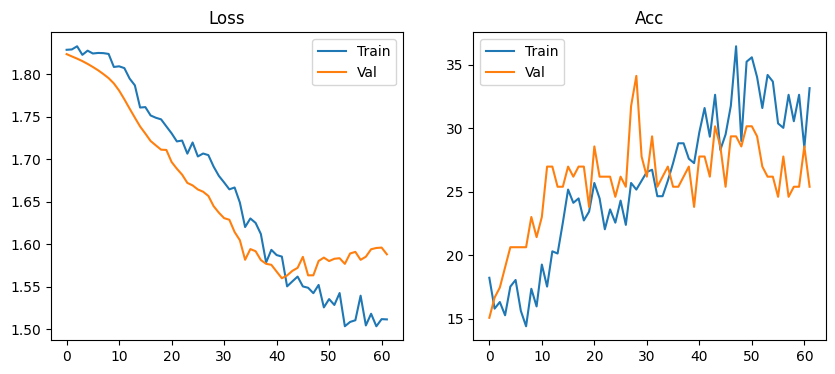


--- TEST SET ---
                 precision    recall  f1-score   support

 Bearish Normal       0.55      0.32      0.41        34
Bearish Pennant       0.08      0.20      0.11        10
  Bearish Wedge       0.37      0.41      0.39        17
 Bullish Normal       0.50      0.03      0.06        33
Bullish Pennant       0.22      0.57      0.32        14
  Bullish Wedge       0.21      0.28      0.24        18

       accuracy                           0.27       126
      macro avg       0.32      0.30      0.25       126
   weighted avg       0.39      0.27      0.26       126



In [61]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# --- KONFIGURÁCIÓ ---
# Ha Dockerben vagy:
OUTPUT_DIR = "/app/output"
if not os.path.exists(OUTPUT_DIR): OUTPUT_DIR = "./output"
LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# ==========================================
# 1. DATASET + AUGMENTATION
# ==========================================
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50, augment=False):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.augment = augment  # Ha True, akkor zajt adunk hozzá
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']

            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            # Normalizálás
            seg_min = segment.min(axis=0)
            seg_max = segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)

            # Tensorrá alakítás
            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32)

            # --- AUGMENTATION (Csak tanításkor!) ---
            if self.augment:
                # 1. Zaj (Gaussian Noise)
                noise = torch.randn_like(tensor_segment) * 0.02  # 2% zaj
                tensor_segment = tensor_segment + noise

                # 2. Skálázás (Scaling) - Kicsit összenyomjuk/széthúzzuk az értékeket
                scale = 1.0 + (np.random.rand() - 0.5) * 0.1 # +/- 5%
                tensor_segment = tensor_segment * scale

            # Interpoláció
            tensor_segment = tensor_segment.permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, 4)), torch.tensor(0, dtype=torch.long)

# ==========================================
# 2. MODELL (Small Transformer)
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class FlagTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, seq_len):
        super().__init__()

        self.input_embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        self.bn_input = nn.BatchNorm1d(d_model) # Batch Norm segít a stabilitásban

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 32), # Kisebb bottleneck
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.input_embedding(x)
        x = self.pos_encoder(x)

        x = x.permute(0, 2, 1)
        x = self.bn_input(x)
        x = x.permute(0, 2, 1)

        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        logits = self.fc_out(x)
        return logits

# ==========================================
# 3. TRAINING FUNCTION
# ==========================================
def train_transformer_v3(
    output_dir="./output",
    batch_size=64,
    d_model=32,          # CSÖKKENTVE (64->32)
    num_heads=4,         # CSÖKKENTVE (8->4)
    num_layers=2,        # CSÖKKENTVE (4->2)
    dim_feedforward=64,  # CSÖKKENTVE (128->64)
    dropout=0.5,         # NÖVELVE (0.4->0.5)
    learning_rate=0.001,
    epochs=100,
    weight_decay=1e-2,   # NÖVELVE (Erősebb regularizáció)
    patience=20
):
    print(f"\n--- STARTING TRAINING V3 (Augmentation + Small Model) ---")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    label_path = os.path.join(output_dir, 'ground_truth_labels.csv')
    if not os.path.exists(label_path): return

    # Adatok
    df_labels = pd.read_csv(label_path)
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)

    if len(df_labels) < 32: return

    # Encode & Split
    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(output_dir, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # Class Weights
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Loaders - ITT KAPCSOLJUK BE AZ AUGMENTATION-t a Train-re!
    train_loader = DataLoader(FlagDataset(train, output_dir, augment=True), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(FlagDataset(val, output_dir, augment=False), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, output_dir, augment=False), batch_size=batch_size, shuffle=False)

    # Modell
    model = FlagTransformer(
        input_size=4, num_classes=num_classes, d_model=d_model,
        nhead=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward,
        dropout=dropout, seq_len=50
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))

    # Loop
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}%")

        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(output_dir, 'transformer_model_v3.pth'))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[STOP] Early Stopping: Loss nem javul.")
                break

    # Viz
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.title('Loss'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.title('Acc'); plt.legend()
    plt.show()

    # Final Test
    print("\n--- TEST SET ---")
    model.load_state_dict(torch.load(os.path.join(output_dir, 'transformer_model_v3.pth'), weights_only=True))
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    train_transformer_v3()


--- TRAINING V4 (Hybrid CNN-Transformer + Focal Loss) ---
Eszköz: cpu
Tanítás indul...


/home/bence/PycharmProjects/Melytanulas/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/120 | Loss: 1.2676/1.2947 | Acc: 22.7%/13.5%
Epoch 2/120 | Loss: 1.2869/1.2897 | Acc: 18.1%/13.5%
Epoch 3/120 | Loss: 1.2577/1.2839 | Acc: 20.7%/15.1%
Epoch 4/120 | Loss: 1.2390/1.2740 | Acc: 24.0%/14.3%
Epoch 5/120 | Loss: 1.2368/1.2601 | Acc: 23.8%/17.5%
Epoch 6/120 | Loss: 1.2137/1.2447 | Acc: 25.3%/19.8%
Epoch 7/120 | Loss: 1.1859/1.2280 | Acc: 24.1%/20.6%
Epoch 8/120 | Loss: 1.2012/1.2091 | Acc: 21.7%/21.4%
Epoch 9/120 | Loss: 1.1905/1.1867 | Acc: 21.9%/19.8%
Epoch 10/120 | Loss: 1.1628/1.1630 | Acc: 24.5%/19.0%
Epoch 11/120 | Loss: 1.1411/1.1363 | Acc: 21.0%/19.0%
Epoch 12/120 | Loss: 1.0954/1.1116 | Acc: 23.4%/19.8%
Epoch 13/120 | Loss: 1.0790/1.0986 | Acc: 27.3%/19.8%
Epoch 14/120 | Loss: 1.0680/1.0776 | Acc: 26.7%/22.2%
Epoch 15/120 | Loss: 1.0620/1.0530 | Acc: 26.9%/25.4%
Epoch 16/120 | Loss: 1.0489/1.0432 | Acc: 25.7%/23.0%
Epoch 17/120 | Loss: 1.0557/1.0487 | Acc: 26.2%/21.4%
Epoch 18/120 | Loss: 1.0241/1.0454 | Acc: 27.6%/22.2%
Epoch 19/120 | Loss: 1.0158/1.0388 | 

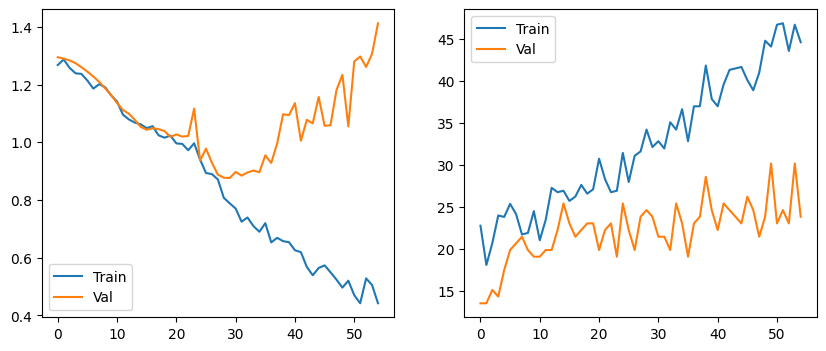


--- TEST SET ---
                 precision    recall  f1-score   support

 Bearish Normal       0.54      0.21      0.30        34
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.20      0.41      0.27        17
 Bullish Normal       0.50      0.03      0.06        33
Bullish Pennant       0.24      0.43      0.31        14
  Bullish Wedge       0.27      0.50      0.35        18

       accuracy                           0.24       126
      macro avg       0.29      0.26      0.21       126
   weighted avg       0.37      0.24      0.22       126



In [62]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# --- KONFIGURÁCIÓ ---
OUTPUT_DIR = "./output"
LABEL_FILE = os.path.join(OUTPUT_DIR, 'ground_truth_labels.csv')

# --- HIPERPARAMÉTEREK V4 ---
BATCH_SIZE = 64
SEQUENCE_LENGTH = 50
INPUT_SIZE = 4
D_MODEL = 64
NUM_HEADS = 4
NUM_LAYERS = 2
DIM_FEEDFORWARD = 128
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 120
WEIGHT_DECAY = 1e-2
PATIENCE = 25

# ==========================================
# 1. FOCAL LOSS (Az új csodafegyver)
# ==========================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Osztálysúlyok
        self.gamma = gamma # Fókuszáló paraméter (minél nagyobb, annál jobban bünteti a nehezeket)
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss) # Valószínűség, amit a modell tippelt a helyes osztályra
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss # (1-pt)^gamma a fókuszáló faktor

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ==========================================
# 2. DATASET + MASKING
# ==========================================
class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50, augment=False):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.augment = augment
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min, seg_max = segment.min(axis=0), segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)
            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32)

            # --- FEJLETT AUGMENTÁCIÓ ---
            if self.augment:
                # 1. Zaj
                tensor_segment += torch.randn_like(tensor_segment) * 0.01

                # 2. Skálázás
                scale = 1.0 + (np.random.rand() - 0.5) * 0.1
                tensor_segment *= scale

                # 3. Time Masking (Véletlenszerűen kinullázunk egy sávot)
                # Max a hossz 10%-át takarjuk ki
                mask_len = int(self.seq_len * 0.1)
                mask_start = np.random.randint(0, len(tensor_segment) - mask_len)
                # Figyelünk, hogy ne indexeljünk túl (bár az interpoláció előtt vagyunk, a hossz változó)
                # Inkább az interpoláció után maszkolunk, az biztonságosabb.

            # Interpoláció
            tensor_segment = tensor_segment.permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0) # [50, 4]

            # 3. Time Masking (Interpoláció után)
            if self.augment and np.random.rand() > 0.5:
                mask_len = 5 # 5 gyertya a 50-ből
                start = np.random.randint(0, 50 - mask_len)
                tensor_final[start:start+mask_len, :] = 0.0 # Kinullázás

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, INPUT_SIZE)), torch.tensor(0, dtype=torch.long)

# ==========================================
# 3. HYBRID MODELL (CNN + Transformer)
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class HybridTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, seq_len):
        super().__init__()

        # 1. CNN FEATURE EXTRACTOR
        # A CNN [Batch, Channel, Seq] formátumot vár!
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.ReLU()
        )

        # 2. TRANSFORMER
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3. HEAD
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [Batch, Seq, Features] -> [Batch, Features, Seq] a CNN-nek
        x = x.permute(0, 2, 1)

        # CNN Feature Extraction
        x = self.cnn(x) # -> [Batch, D_Model, Seq]

        # Visszaalakítás Transformernek -> [Batch, Seq, D_Model]
        x = x.permute(0, 2, 1)

        # Transformer Process
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)

        # Global Average Pooling
        x = x.mean(dim=1)

        logits = self.fc_out(x)
        return logits

# ==========================================
# 4. TRAINING FUNCTION
# ==========================================
def train_hybrid_v4():
    print(f"\n--- TRAINING V4 (Hybrid CNN-Transformer + Focal Loss) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Eszköz: {device}")

    if not os.path.exists(LABEL_FILE): return
    df_labels = pd.read_csv(LABEL_FILE)
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)
    if len(df_labels) < 32: return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(OUTPUT_DIR, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # Class Weights a Focal Loss-hoz (alpha)
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_loader = DataLoader(FlagDataset(train, OUTPUT_DIR, augment=True), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(FlagDataset(val, OUTPUT_DIR, augment=False), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, OUTPUT_DIR, augment=False), batch_size=BATCH_SIZE, shuffle=False)

    # HYBRID MODELL
    model = HybridTransformer(
        input_size=INPUT_SIZE, num_classes=num_classes, d_model=D_MODEL,
        nhead=NUM_HEADS, num_layers=NUM_LAYERS, dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT, seq_len=SEQUENCE_LENGTH
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # FOCAL LOSS
    criterion = FocalLoss(alpha=weights_tensor, gamma=2.0)

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=len(train_loader))

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print("Tanítás indul...")
    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}%")

        if v_acc >= best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'hybrid_model_v4.pth'))

        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"[STOP] Early Stopping: {PATIENCE} epoch."); break

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.legend()
    plt.show()

    print("\n--- TEST SET ---")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'hybrid_model_v4.pth'), weights_only=True))
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

if __name__ == "__main__":
    train_hybrid_v4()


--- HYBRID TRAINING (CNN + Transformer) ---
Config: D=32, CNN=16, LR=0.0001, Batch=128


/home/bence/PycharmProjects/Melytanulas/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/150 | Loss: 1.3334/1.3103 | Acc: 17.0%/27.0% | LR: 0.000004
Epoch 2/150 | Loss: 1.2903/1.3089 | Acc: 16.0%/27.0% | LR: 0.000004
Epoch 3/150 | Loss: 1.3332/1.3077 | Acc: 20.1%/27.0% | LR: 0.000005
Epoch 4/150 | Loss: 1.3175/1.3074 | Acc: 14.8%/27.0% | LR: 0.000006
Epoch 5/150 | Loss: 1.3707/1.3075 | Acc: 17.0%/27.0% | LR: 0.000007
Epoch 6/150 | Loss: 1.3375/1.3080 | Acc: 16.0%/27.0% | LR: 0.000008
Epoch 7/150 | Loss: 1.2991/1.3079 | Acc: 18.2%/26.2% | LR: 0.000010
Epoch 8/150 | Loss: 1.3030/1.3070 | Acc: 16.8%/25.4% | LR: 0.000011
Epoch 9/150 | Loss: 1.3087/1.3054 | Acc: 18.4%/25.4% | LR: 0.000013
Epoch 10/150 | Loss: 1.2831/1.3031 | Acc: 18.6%/26.2% | LR: 0.000015
Epoch 11/150 | Loss: 1.3168/1.3005 | Acc: 15.2%/24.6% | LR: 0.000018
Epoch 12/150 | Loss: 1.3037/1.2982 | Acc: 21.3%/24.6% | LR: 0.000020
Epoch 13/150 | Loss: 1.3071/1.2959 | Acc: 18.8%/24.6% | LR: 0.000023
Epoch 14/150 | Loss: 1.3024/1.2936 | Acc: 18.0%/25.4% | LR: 0.000025
Epoch 15/150 | Loss: 1.3168/1.2915 | Acc: 1

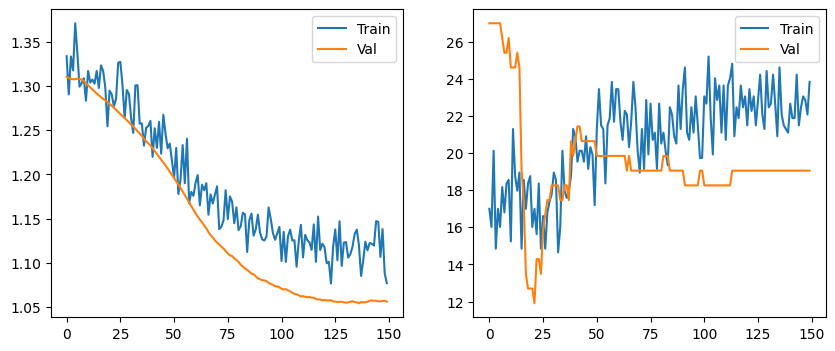


--- FINAL TEST SET EVALUATION ---
                 precision    recall  f1-score   support

 Bearish Normal       0.27      1.00      0.42        34
Bearish Pennant       0.00      0.00      0.00        10
  Bearish Wedge       0.00      0.00      0.00        17
 Bullish Normal       0.00      0.00      0.00        33
Bullish Pennant       0.00      0.00      0.00        14
  Bullish Wedge       0.00      0.00      0.00        18

       accuracy                           0.27       126
      macro avg       0.04      0.17      0.07       126
   weighted avg       0.07      0.27      0.11       126



In [63]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import math

# --- KONFIGURÁCIÓ ---
DEFAULT_OUTPUT_DIR = "./output" if os.path.exists("/app/output") else "./output"

# ==========================================
# 1. CLASSES (Dataset, Loss, Model)
# ==========================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean': return focal_loss.mean()
        elif self.reduction == 'sum': return focal_loss.sum()
        else: return focal_loss

class FlagDataset(Dataset):
    def __init__(self, metadata, csv_dir, seq_len=50, augment=False):
        self.metadata = metadata
        self.csv_dir = csv_dir
        self.seq_len = seq_len
        self.augment = augment
        self.loaded_dfs = {}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        uniform_name = row['raw_csv_filename']
        csv_filename = f"merged_{uniform_name}.csv"
        csv_path = os.path.join(self.csv_dir, csv_filename)

        if uniform_name not in self.loaded_dfs:
            if os.path.exists(csv_path):
                try: self.loaded_dfs[uniform_name] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                except: self.loaded_dfs[uniform_name] = None
            else: self.loaded_dfs[uniform_name] = None

        df = self.loaded_dfs[uniform_name]
        if df is None: return self._get_dummy()

        try:
            start_ts = row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
            end_ts = row['flag_end_ts']
            mask = (df.index >= pd.to_datetime(start_ts)) & (df.index <= pd.to_datetime(end_ts))
            segment = df.loc[mask, ['open', 'high', 'low', 'close']].values

            if len(segment) < 2: return self._get_dummy()

            seg_min, seg_max = segment.min(axis=0), segment.max(axis=0)
            denom = seg_max - seg_min + 1e-6
            segment_norm = (segment - seg_min) / denom
            segment_norm = np.nan_to_num(segment_norm, nan=0.0, posinf=1.0, neginf=0.0)
            tensor_segment = torch.tensor(segment_norm, dtype=torch.float32)

            if self.augment:
                tensor_segment += torch.randn_like(tensor_segment) * 0.01
                scale = 1.0 + (np.random.rand() - 0.5) * 0.1
                tensor_segment *= scale

            tensor_segment = tensor_segment.permute(1, 0).unsqueeze(0)
            tensor_resized = torch.nn.functional.interpolate(tensor_segment, size=self.seq_len, mode='linear', align_corners=False)
            tensor_final = tensor_resized.squeeze(0).permute(1, 0)

            if self.augment and np.random.rand() > 0.5:
                mask_len = 5
                start = np.random.randint(0, self.seq_len - mask_len)
                tensor_final[start:start+mask_len, :] = 0.0

            if torch.isnan(tensor_final).any(): return self._get_dummy()
            return tensor_final, torch.tensor(row['label_idx'], dtype=torch.long)

        except: return self._get_dummy()

    def _get_dummy(self):
        return torch.zeros((self.seq_len, 4)), torch.tensor(0, dtype=torch.long)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class HybridTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, seq_len, cnn_channels):
        super().__init__()

        # 1. CNN (Parametrizálható csatornaszámmal)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_channels, out_channels=d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.ReLU()
        )

        # 2. Transformer
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3. Head
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) # [Batch, Features, Seq]
        x = self.cnn(x)
        x = x.permute(0, 2, 1) # [Batch, Seq, D_Model]

        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)

        logits = self.fc_out(x)
        return logits

# ==========================================
# 2. TRAIN FUNCTION (HYBRID)
# ==========================================
def train_hybrid_model(
    output_dir=DEFAULT_OUTPUT_DIR,
    label_file="ground_truth_labels.csv",
    # V5 Hyperparaméterek (Default)
    batch_size=64,
    d_model=64,
    num_heads=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.5,
    learning_rate=0.001,
    epochs=100,
    cnn_channels=32, # ÚJ paraméter
    patience=20
):
    print(f"\n--- HYBRID TRAINING (CNN + Transformer) ---")
    print(f"Config: D={d_model}, CNN={cnn_channels}, LR={learning_rate}, Batch={batch_size}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    full_label_path = os.path.join(output_dir, label_file)

    if not os.path.exists(full_label_path): return

    df_labels = pd.read_csv(full_label_path)
    allowed = ['EURUSD', 'XAU']
    df_labels = df_labels.dropna(subset=['raw_csv_filename'])
    mask = df_labels['raw_csv_filename'].apply(lambda x: any(a in str(x) for a in allowed))
    df_labels = df_labels[mask].reset_index(drop=True)
    if len(df_labels) < 32: return

    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])
    num_classes = len(le.classes_)
    np.save(os.path.join(output_dir, 'classes.npy'), le.classes_)

    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_loader = DataLoader(FlagDataset(train, output_dir, augment=True), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(FlagDataset(val, output_dir, augment=False), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(FlagDataset(test, output_dir, augment=False), batch_size=batch_size, shuffle=False)

    model = HybridTransformer(
        input_size=4, num_classes=num_classes, d_model=d_model,
        nhead=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward,
        dropout=dropout, seq_len=50, cnn_channels=cnn_channels
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
    criterion = FocalLoss(alpha=weights_tensor, gamma=2.0)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))

    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_t_loss = train_loss / len(train_loader)
        t_acc = 100 * correct / total

        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        avg_v_loss = val_loss / len(val_loader)
        v_acc = 100 * v_correct / v_total

        history['train_loss'].append(avg_t_loss)
        history['val_loss'].append(avg_v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | Acc: {t_acc:.1f}%/{v_acc:.1f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if v_acc >= best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), os.path.join(output_dir, 'hybrid_model_final.pth'))

        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[STOP] Early Stopping."); break

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.legend()
    plt.show()

    print("\n--- FINAL TEST SET EVALUATION ---")
    model.load_state_dict(torch.load(os.path.join(output_dir, 'hybrid_model_final.pth'), weights_only=True))
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=le.classes_, zero_division=0))

# ==========================================
# 3. RUN WITH OPTIMIZED SETTINGS (V5)
# ==========================================
if __name__ == "__main__":
    train_hybrid_model(
        batch_size=128,        # NÖVELVE a stabilitásért
        d_model=32,            # Kicsi marad
        num_heads=4,
        num_layers=2,
        dropout=0.6,           # MAXIMÁLIS DROPOUT
        learning_rate=0.0001,  # CSÖKKENTETT LR (Finomhangolás)
        epochs=150,            # Több idő
        cnn_channels=16,       # CSÖKKENTVE (Kevesebb zajt enged át a CNN)
        patience=30
    )